In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

/Users/rodolfolobocarrasco/.pyenv/versions/3.11.6/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data

In [2]:
# Descarga y carga el conjunto de datos MNIST

# Compone la transformación de una imagen en una serie-secuencia de pasos:
# 1 - Convierte las imagenes del conjunto de datos a tensores
# 2 - normaliza las imagenes en el rango -1,1 y luego estandariza para que tengan media 0 varianza 1 (resta 0.5 y divide por 0.5)
# 3 - Descarga el conjunto de imagene y le aplica la transformación
# 4 - Clase que permite dividir el cojunto de datos en lotes (batches) y los "baraja" de manera aleatoria.
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.5], std=[0.5])])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


### Modelo

In [3]:
# Define la arquitectura de la red convolucional simple
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  #(1: canal, 16: filtros, cada filtro tendra tamano 3x3, stride: tamano del paso, padding: añade un pixel a cada lado de la entrada)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 7 * 7)
        x = self.fc1(x)
        return x

## Instanciando

In [4]:
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Entrenando

Utilizaremos apenas 5 épocas a modo de ejemplo

In [5]:
num_epochs = 5
losses = []  # Lista para almacenar las pérdidas

for epoch in range(num_epochs):
    epoch_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/5], Loss: 0.1504
Epoch [2/5], Loss: 0.0491
Epoch [3/5], Loss: 0.0377
Epoch [4/5], Loss: 0.0294
Epoch [5/5], Loss: 0.0237


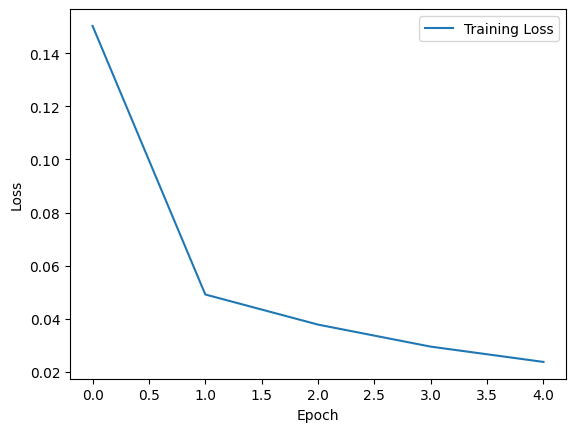

In [6]:
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualizando las activaciones

In [7]:
sample_image, _ = train_dataset[0]
sample_image = sample_image.unsqueeze(0)  # Agrega una dimensión de lote
activation = {}

## Observemos un ejemplo

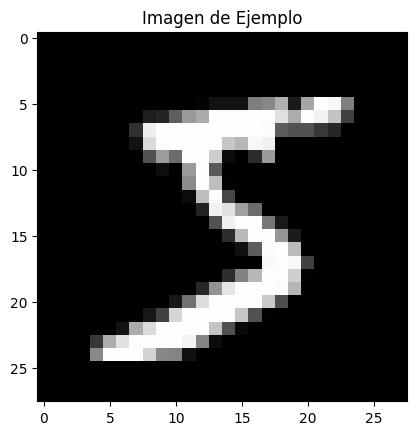

In [8]:
# Desnormalizar la imagen (deshacer la normalización aplicada anteriormente)
sample_image_vis = sample_image * 0.5 + 0.5

# Convertir el tensor de la imagen a un arreglo NumPy
sample_image_vis = sample_image.numpy()

# Mostrar la imagen
plt.imshow(sample_image_vis.squeeze(), cmap='gray')
plt.title("Imagen de Ejemplo")
plt.show()

## Función de Gancho

[Aquí](https://tivadardanka.com/blog/hooks-the-one-pytorch-trick-you-must-know) más información sobre esta estrategia

In [9]:
# Aqui almacenaré la salida de la capa en un diccionario llamado activación con la llave "value"
def hook_fn(module, input, output):
    activation['value'] = output

# La primera capa convolucional del modelo recibe a través del método "register_forward_hook" el método hook_fn
# Y será un puente o gancho que se ejecutara una vez que el modelo calcule la primera capa
# Es decir, cuando conv1 procesa una entrada hook_fn se activa y almacena la salida en el diccionario
model.conv1.register_forward_hook(hook_fn)

## Observando las salidas de la primera capa

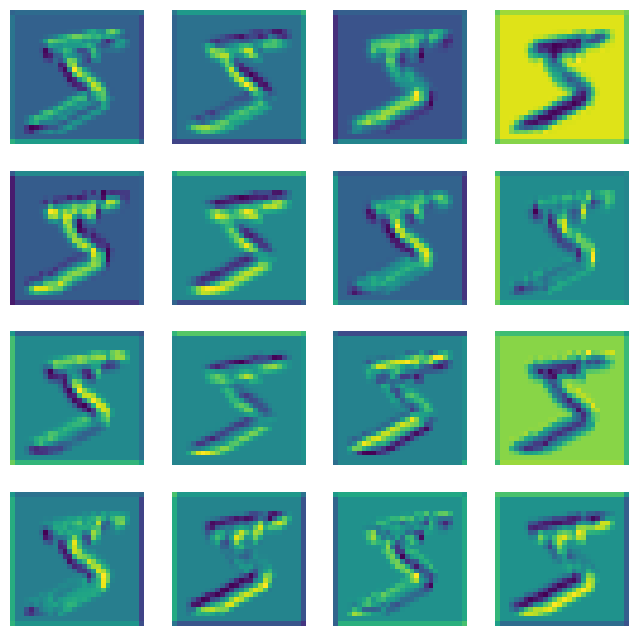

In [10]:
# Pasa la muestra de imagen a través de la red para poder generar salidas y observarlas solo en la primera capa!
model(sample_image)

# Visualiza las activaciones de la primera capa convolucional
activations = activation['value'].squeeze().detach().numpy()
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(activations[i], cmap='viridis')
    plt.axis('off')
plt.show()


## Visualicemos las 2 capas: extensión del hook

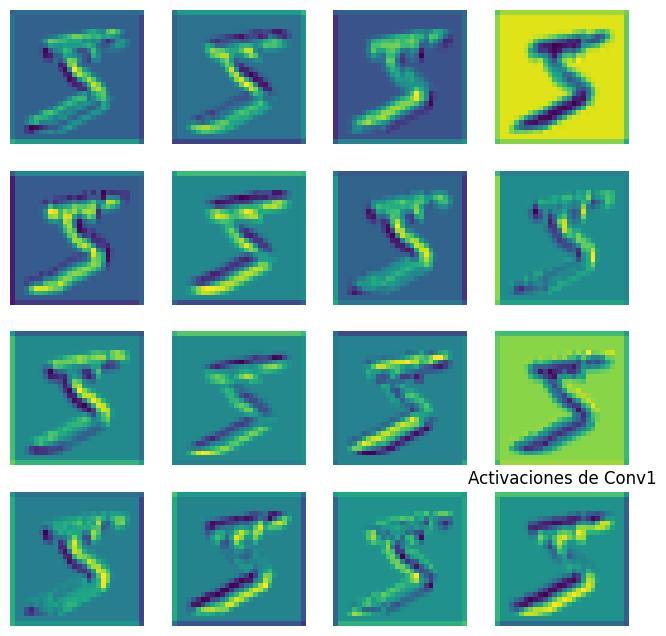

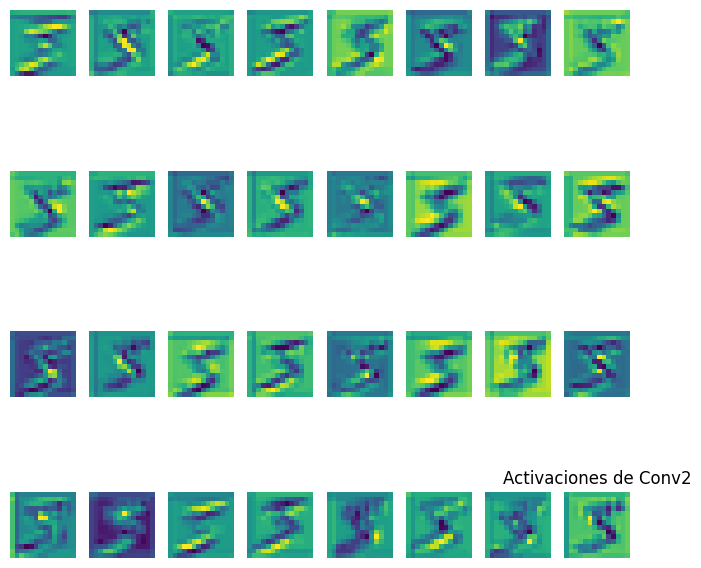

In [11]:
# Diccionario para almacenar las activaciones de ambas capas
activations = {'conv1': None, 'conv2': None}

# Función de gancho para capturar las activaciones
def hook_fn(module, input, output, layer_name):
    activations[layer_name] = output

# Registrar ganchos para ambas capas y usamos una función lambda por necesitamos pasar 2 nombres
model.conv1.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'conv1'))
model.conv2.register_forward_hook(lambda m, i, o: hook_fn(m, i, o, 'conv2'))

# Pasa la muestra de imagen a través del modelo
model(sample_image)

# Visualizar las activaciones de la primera capa
activations_conv1 = activations['conv1'].squeeze().detach().numpy()
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(activations_conv1[i], cmap='viridis')
    plt.axis('off')
plt.title('Activaciones de Conv1')
plt.show()

# Visualizar las activaciones de la segunda capa
activations_conv2 = activations['conv2'].squeeze().detach().numpy()
plt.figure(figsize=(8, 8))
for i in range(32):
    plt.subplot(4, 8, i + 1)
    plt.imshow(activations_conv2[i], cmap='viridis')
    plt.axis('off')
plt.title('Activaciones de Conv2')
plt.show()